# Tutorial 2: Hair follicle profiled with SHARE-seq (ATAC-seq + RNA-seq)

Tutorials 2 and 3 investigate a multimodal single-cell hair follicle dataset by [Ma et al., 2020](https://www.sciencedirect.com/science/article/pii/S0092867420312538). Data comes from female mouse dorsal skin and consists of two single-cell modalities: ATAC-seq (chromatin accessibility, raw data available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156597)) and RNA-seq (gene expression, raw data available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4156608)).

In Tutorial 1, you visualized MDM components with both ForceAtlas2 and UMAP. Ocelli implements an extended force-directed layout approach that uses transition probabilities (velocities) between cells. There are a few methods modeling transition probabilities between cells, such as [Velocyto](https://doi.org/10.1038/s41586-018-0414-6), [scVelo](https://www.nature.com/articles/s41587-020-0591-3), [MultiVelo](https://www.nature.com/articles/s41587-022-01476-y), or [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X). In this tutorial, you will construct the MDM embedding of the hair follicle dataset and learn how to use RNA dynamics information when creating the graph for force-directed data visualization.

## Loading and processing data

Download filtered data, available on [figshare](https://doi.org/10.6084/m9.figshare.28303598.v1), and import necessary packages.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import ocelli as oci
import anndata as ad
import scvelo as scv
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.colors import LinearSegmentedColormap

! wget --content-disposition https://figshare.com/ndownloader/articles/28303598/versions/1
! unzip -o 28303598.zip
! rm 28303598.zip

--2025-01-29 18:35:05--  https://figshare.com/ndownloader/articles/28303598/versions/1
52.17.87.113, 54.170.28.5, 2a05:d018:1f4:d000:2b52:700c:3d58:74bf, ...
Connecting to figshare.com (figshare.com)|52.17.87.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167301182 (160M) [application/zip]
Saving to: ‘28303598.zip’

28303598.zip        100%[===================>] 159.55M  15.7MB/s    in 10s     

2025-01-29 18:35:15 (16.0 MB/s) - ‘28303598.zip’ saved [167301182/167301182]

Archive:  28303598.zip
 extracting: hf_shareseq_atac_peaks.h5ad  
 extracting: hf_shareseq_atac.h5ad   
 extracting: hf_shareseq_rna.h5ad    
 extracting: hf_shareseq_signature_HS_Co.csv  
 extracting: hf_shareseq_signature_HS_Me.csv  
 extracting: hf_shareseq_signature_IRS_He.csv  
 extracting: hf_shareseq_signature_IRS_Hu.csv  


Load gene expression data. We generated the RNA-seq annotated matrix from raw BAM files with [Velocyto](https://doi.org/10.1038/s41586-018-0414-6) and then filtered cells and genes. Filtering steps are described in detail in the paper. The resulting count matrix has 7,160 cells and 6,731 genes, together with unspliced (`hf.layers['unspliced']`) and spliced (`hf.layers['spliced']`) expression layers needed for RNA velocity calculation.

In [2]:
rna = oci.read.h5ad('hf_shareseq_rna.h5ad')

rna

AnnData object with n_obs × n_vars = 7160 × 6731
    obs: 'celltype', 'doublet_scores', 'n_genes', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Ocelli's data preprocessing is based on topic modeling, a data compression approach that organizes features into cohesive groups (topics). Each cell is modeled as a probabilistic topic mixture, with highly-expressed topics being more probable. These distributions form highly-compressed and information-rich latent spaces on which we train models. Topic distributions are cell-normalized; therefore, no further normalization is needed.

Ocelli uses Latent Dirichlet Allocation (LDA), a generative Bayesian topic model, which has become the golden standard in the field. We run LDA on filtered count matrices, with low-quality cells/features removed. LDA has two major parameters: `n_components` (the number of topics) and `max_iter` (the maximum number of LDA's training iterations).

Compute 50 LDA topics on the RNA-seq count matrix. Downloaded data includes precomputed topics.

In [3]:
#oci.pp.lda(rna, n_components=50, max_iter=50, random_state=SEED, n_jobs=50, verbose=1)

Estimate RNA velocities with [scVelo](https://scvelo.readthedocs.io) on 1,000 log-normalized highly variable genes.

In [4]:
scv.pp.normalize_per_cell(rna, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(rna, n_top_genes=1000)
scv.pp.log1p(rna)

scv.tl.velocity(rna, mode='stochastic')
scv.tl.velocity_graph(rna)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors


/tmp/ipykernel_503489/1920998570.py:3: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(rna)


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/7160 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Load the chromatin accessibility data. We generated the ATAC-seq count matrix with [Signac](https://stuartlab.org/signac/index.html) by mapping chromatin accessibility fragments to gene regions, including the 2kb upstream. Next, we filtered low-quality genes, resulting in 17,495 genes.

In [5]:
atac = oci.read.h5ad('hf_shareseq_atac.h5ad')

atac

AnnData object with n_obs × n_vars = 7160 × 17495
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'

Compute 50 LDA topics on the ATAC-seq count matrix. Downloaded data includes precomputed topics.

In [6]:
#oci.pp.lda(atac, n_components=50, max_iter=50, random_state=17, n_jobs=50, verbose=1)

## Multimodal Diffusion Maps

Create a joint `AnnData` object for both modalities to start multimodal analysis. It must include preprocessed modality arrays saved in `hf.obsm` and a list of their keys stored in `hf.uns`. Everything else is optional.

In [7]:
# create empty AnnData object
hf = ad.AnnData(csr_matrix(([],([],[])), shape=(7160, 1000)))

# save modality arrays
hf.obsm['rna'] = rna.obsm['X_lda']
hf.obsm['atac'] = atac.obsm['X_lda']
hf.uns['modalities'] = ['rna', 'atac']

# save cell metadata
hf.obs.index = list(rna.obs.index)
hf.obs['celltype'] = list(rna.obs['celltype'])

# save RNA velocity data
hf.uns['velocity_graph'] = rna.uns['velocity_graph']
hf.uns['velocity_graph_neg'] = rna.uns['velocity_graph_neg']
hf.layers['velocity'] = rna.layers['velocity']

hf

AnnData object with n_obs × n_vars = 7160 × 1000
    obs: 'celltype'
    uns: 'modalities', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'rna', 'atac'
    layers: 'velocity'

Follow the MDM workflow: compute nearest neighbors across modalities, multimodal weights, and the low-dimensional MDM embedding.

In [8]:
oci.pp.neighbors(hf, n_neighbors=20, n_jobs=50, verbose=True)
oci.tl.modality_weights(hf, random_state=17, n_jobs=50, verbose=True)
oci.tl.MDM(hf, n_components=20, random_state=17, n_jobs=50, verbose=True)

[rna]	20 nearest neighbors calculated.
[atac]	20 nearest neighbors calculated.


2025-01-29 18:35:29,401	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2025-01-29 18:35:35,201	INFO worker.py:1518 -- Started a local Ray instance.


[rna]	Unimodal Markov chain calculated.
[atac]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculated.


## Visualizing MDM components with RNA velocity

With Ocelli, you can incorporate transition probabilities between cells (such as RNA velocities) when constructing low-dimensional embeddings. `oci.tl.transitions_graph` builds the graph for force-directed data visualization, which connects a cell to its nearest neighbors with the highest transition probabilities. If the neighborhood has too few cells with non-zero transitions, edges are created towards the nearest neighbors. You may interpret the transitions graph as follows: the MDM latent space represents a global multimodal structure, while RNA transitions align cells locally (within cells' neighborhoods) along a velocity stream.

In [9]:
oci.pp.neighbors(hf, x=['X_mdm'], n_neighbors=100, n_jobs=50, verbose=True)
oci.tl.transitions_graph(hf, x='X_mdm', transitions='velocity_graph', n_edges=3, 
                         n_jobs=50, verbose=True)

[X_mdm]	100 nearest neighbors calculated.
Transitions-based graph constructed.


Compute a 3D FLE.

In [10]:
oci.tl.fa2(hf, n_components=3, random_state=17, n_jobs=50)

Jan 29, 2025 6:35:48 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 29, 2025 6:35:49 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 7,160 (7,160 added)
Jan 29, 2025 6:35:49 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 21,480 (20,575 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 40.751s


Explore multiple 2D projections.

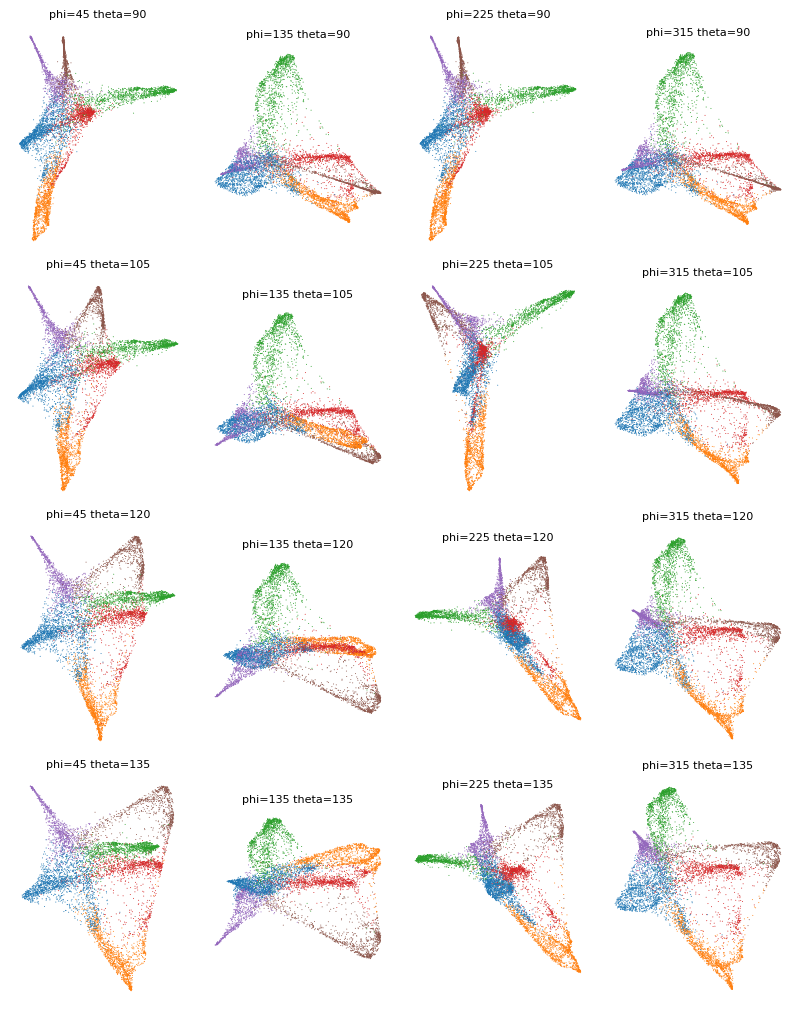

In [11]:
# specify colors for plots
cdict = {'TAC-1': '#1f77b4', 
         'IRS - Henle\'s layer': '#ff7f0e', 
         'HS - Cortex': '#2ca02c',
         'TAC-2': '#d62728',
         'IRS - Huxley\'s layer': '#9467bd', 
         'HS - Medulla': '#8c564b'}

oci.pl.projections(hf, x='X_fa2', c='celltype', phis=[45, 135, 225, 315], 
                   thetas=[90, 105, 120, 135], cdict=cdict, s=0.5, 
                   fontsize=8, figsize=(8, 10), showlegend=False, random_state=17)

Select a projection for further exploration: `phi=135` and `theta=135`.

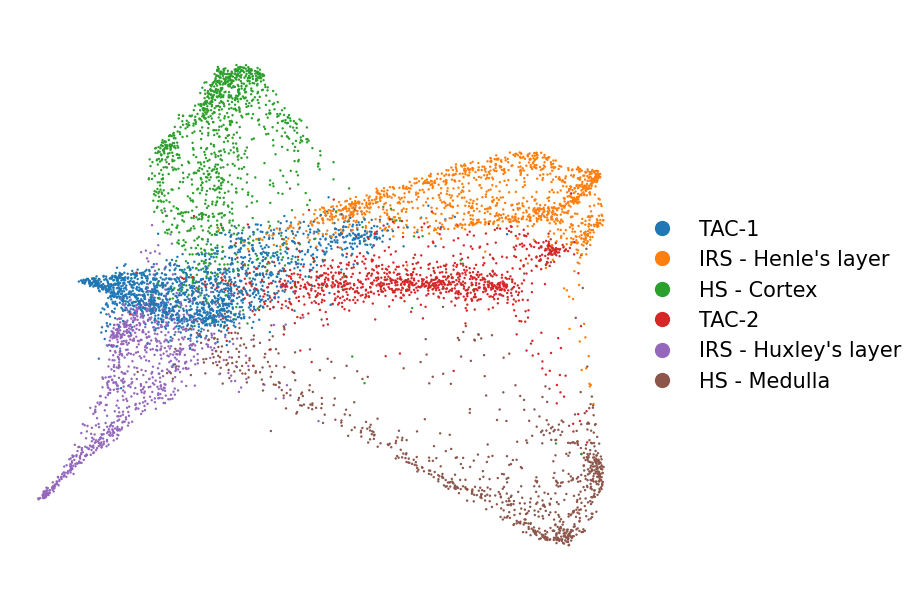

In [12]:
oci.tl.projection(hf, x='X_fa2', phi=135, theta=135, random_state=17)
oci.pl.scatter(hf, x='X_proj', c='celltype', cdict=cdict, s=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title='')

Validate the quality of visualization by plotting the velocity stream.

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_proj', embedded velocity vectors (adata.obsm)


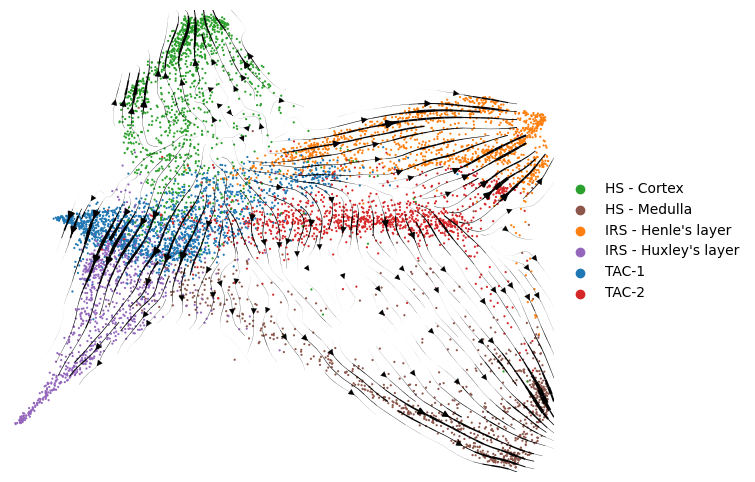

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
scv.pl.velocity_embedding_stream(hf, basis='proj', alpha=1, title='', density=2,
                                 linewidth=2, show=False, ax=ax, color='celltype', 
                                 size=10, legend_fontweight=2, legend_loc='right center', 
                                 palette=cdict)

ax.set_aspect('equal')

## Exploring modality weights

You can investigate multimodal weight distribution in multiple ways. For example, as in Tutorial 1, with scatter and violin plots.

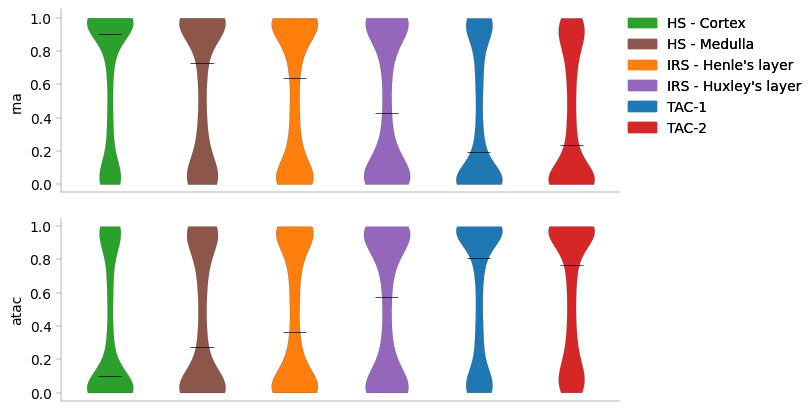

In [14]:
oci.pl.violin(hf, groups='celltype', values='weights', cdict=cdict, fontsize=10, 
              figsize=(8, 4))

Another option is bar plots which show the median or mean weight value per cell group.

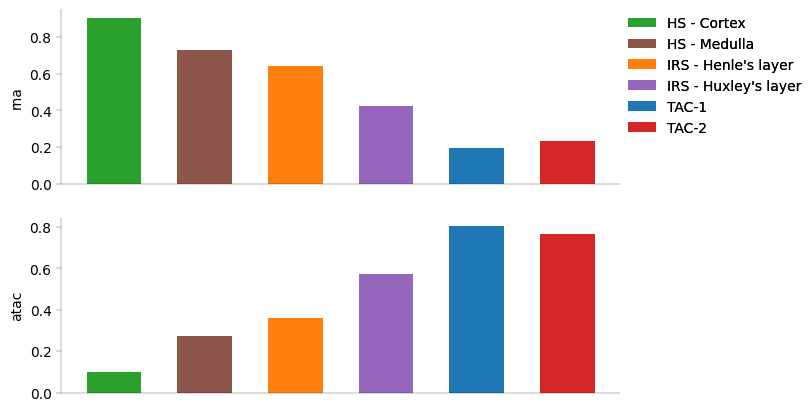

In [15]:
oci.pl.bar(hf, groups='celltype', values='weights', height='median', cdict=cdict, 
           fontsize=10, figsize=(8, 4))

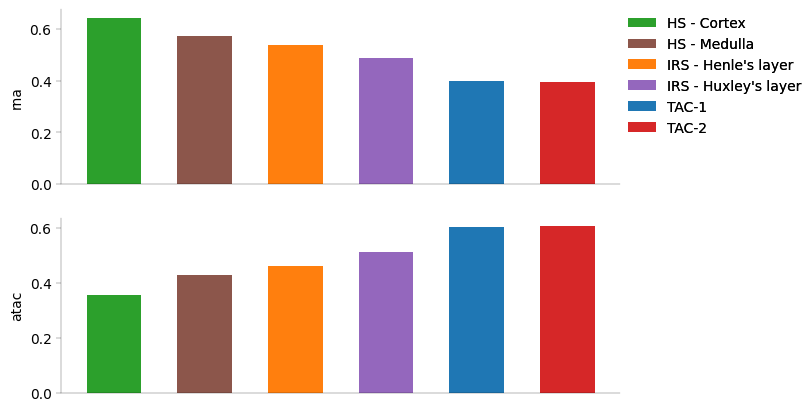

In [16]:
oci.pl.bar(hf, groups='celltype', values='weights', height='mean', cdict=cdict, 
           fontsize=10, figsize=(8, 4))

Chromatin accessibility is a more informative modality for transit-amplifying cells (TACs) and RNA-seq is more informative for later developmental stages in hair shaft (HS) and inner root sheath (IRS).

## Analyzing gene signatures

If you have unannotated cells or you wish to validate existing annotations, inspecting gene markers or gene signatures can help understand your dataset's biology. The hair follicle system was studied in detail by [Yang et al., 2017](https://www.sciencedirect.com/science/article/pii/S0092867417303677), resulting in gene signatures for HS and IRS cell subtypes.

In this section, you will examine hair follicle gene signatures with [z-scores](https://en.wikipedia.org/wiki/Standard_score), a statistic that measures how many standard deviations a value deviates from the mean. A high z-score for a cell indicates that a gene is expressed above the mean. For a gene signature, z-scores are computed for each gene individually and then averaged.

Firstly, log-normalize RNA-seq counts.

In [17]:
rna_sig = oci.read.h5ad('hf_shareseq_rna.h5ad')

sc.pp.normalize_total(rna_sig, target_sum=10000)
sc.pp.log1p(rna_sig)

`oci.tl.mean_z_scores` computes mean z-scores for a signature specified by a list of column indices of the AnnData. `get_indices` converts a list of gene names into a list of `rna_sig.var` indices.

In [18]:
def get_indices(signature, varnames):
    indices = list()

    for gene in signature:
        if gene in varnames:
            indices.append(varnames.index(gene))

    return indices

### Hair shaft (HS) gene signatures

Examine z-scores for HS gene signatures. Start with Medulla.

2025-01-29 18:36:38,248	INFO worker.py:1518 -- Started a local Ray instance.


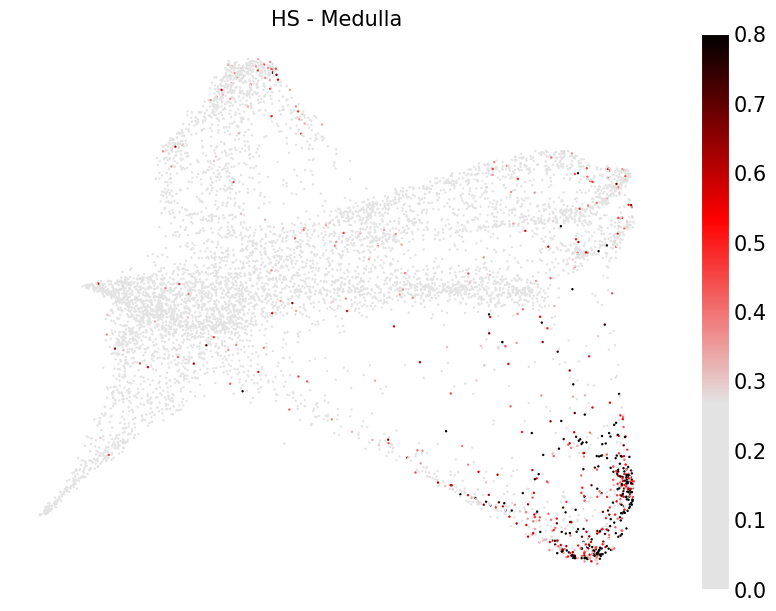

In [19]:
cmap = LinearSegmentedColormap.from_list(
    'custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)

markers = list(pd.read_csv('hf_shareseq_signature_HS_Me.csv', index_col=0).index)
name = 'HS - Medulla'
var_names = list(rna_sig.var.index)
marker_indices = get_indices(markers, var_names)
oci.tl.zscores(rna_sig, markers=marker_indices, n_jobs=50, out=name)
# save z-scores to hf
hf.obs[name] = rna_sig.obs[name]
# plot z-scores
oci.pl.scatter(hf, x='X_proj', c=name, cmap=cmap, s=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.8)

Repeat for Cortex.

2025-01-29 18:36:44,002	INFO worker.py:1518 -- Started a local Ray instance.


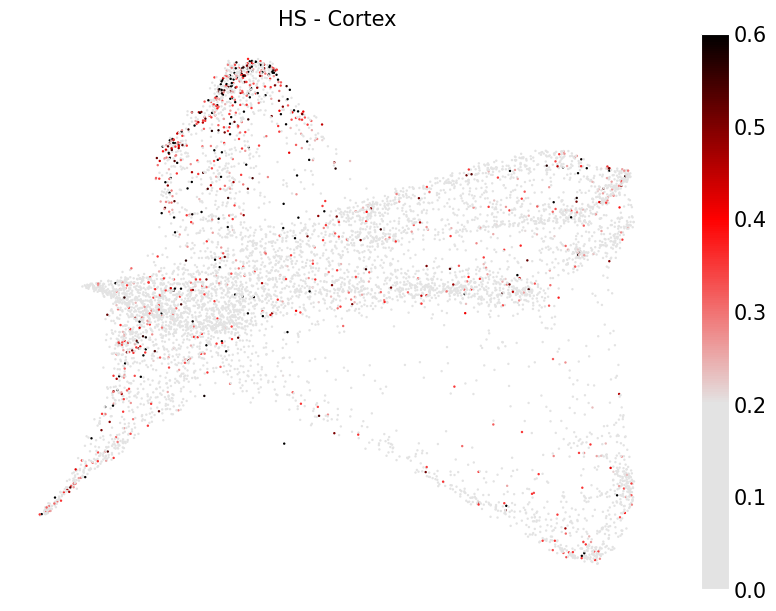

In [20]:
markers = list(pd.read_csv('hf_shareseq_signature_HS_Co.csv', index_col=0).index)
name = 'HS - Cortex'
var_names = list(rna_sig.var.index)

marker_indices = get_indices(markers, var_names)
oci.tl.zscores(rna_sig, markers=marker_indices, out=name, n_jobs=50)

hf.obs[name] = rna_sig.obs[name]
oci.pl.scatter(hf, x='X_proj', c=name, cmap=cmap, s=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.6)

### Inner root sheath (IRS) gene signatures

Repeat procedure for inner root sheath gene signatures.

2025-01-29 18:36:49,847	INFO worker.py:1518 -- Started a local Ray instance.


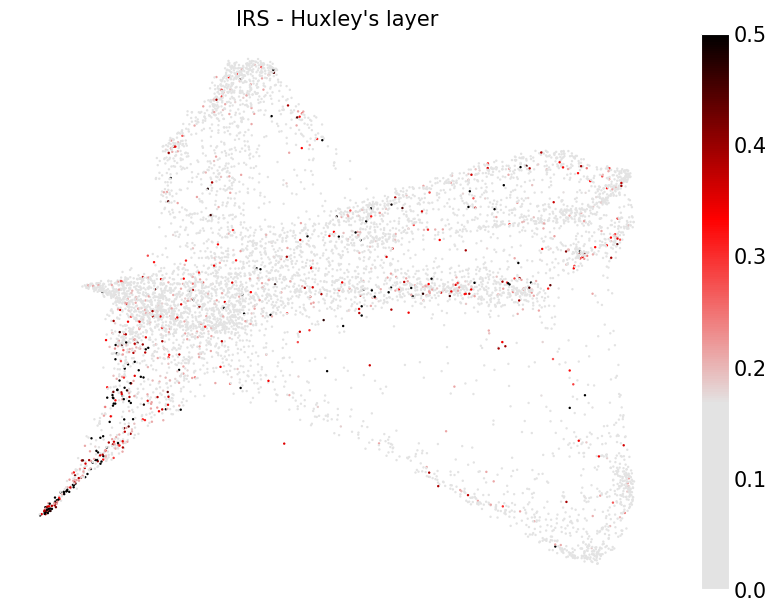

In [21]:
markers = list(pd.read_csv('hf_shareseq_signature_IRS_Hu.csv', index_col=0).index)
name = 'IRS - Huxley\'s layer'
var_names = list(rna_sig.var.index)

marker_indices = get_indices(markers, var_names)
oci.tl.zscores(rna_sig, markers=marker_indices, out=name, n_jobs=50)

hf.obs[name] = rna_sig.obs[name]
oci.pl.scatter(hf, x='X_proj', c=name, cmap=cmap, s=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=0.5)

2025-01-29 18:36:56,644	INFO worker.py:1518 -- Started a local Ray instance.


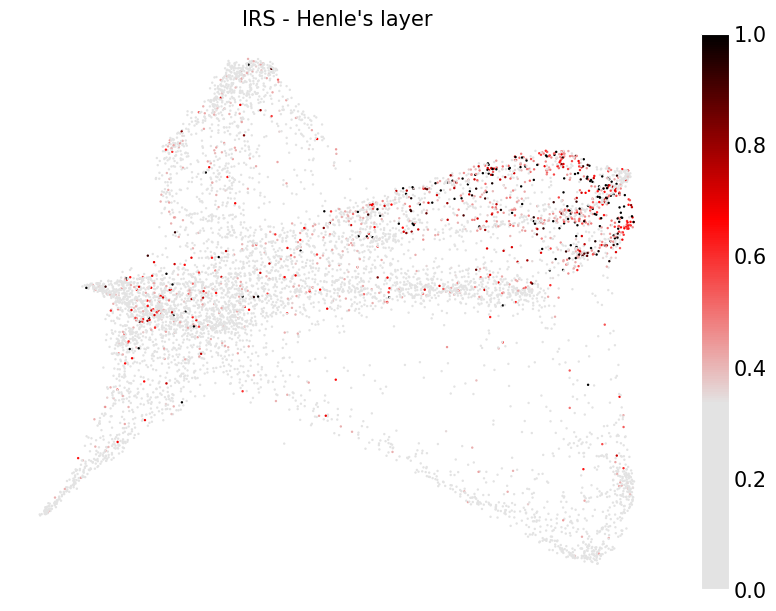

In [22]:
markers = list(pd.read_csv('hf_shareseq_signature_IRS_He.csv', index_col=0).index)
name = 'IRS - Henle\'s layer'
var_names = list(rna_sig.var.index)

marker_indices = get_indices(markers, var_names)
oci.tl.zscores(rna_sig, markers=marker_indices, out=name, n_jobs=50)

hf.obs[name] = rna_sig.obs[name]
oci.pl.scatter(hf, x='X_proj', c=name, cmap=cmap, s=3, markerscale=2, 
               fontsize=15, figsize=(9, 6), title=name, vmin=0, vmax=1)

Ocelli successfully imputed values of highly sparse promoter activity.

In Tutorial 3, you will investigate the diffusion-based multimodal imputation.